In [443]:
#https://plotly.com/python/reference/

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : '#0d1238'}

import io
import json
import os
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
from IPython.display import Markdown, display, Image, clear_output
from PIL import Image as PILImage

# LOCAL GIT REPOSITORY LOCATION FOR https://github.com/CSSEGISandData/COVID-19
directory = '/Users/davidmorton/Documents/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'

!git -C $directory pull

states_to_drop = ['Puerto Rico', 'American Samoa', 'Guam', 'Northern Mariana Islands', 'Virgin Islands']

state_names = pd.read_csv('states.csv').set_index('State').to_dict()['Abbreviation']
bgcolor = '#0d1238'

Already up to date.


In [694]:
def get_census_info():
    county_populations = pd.read_csv("co-est2019-alldata.csv", encoding = "ISO-8859-1")
    county_populations = county_populations[county_populations['SUMLEV'] == 50] # 40 is states, 50 is counties
    county_populations = county_populations[['STATE', 'COUNTY', 'CTYNAME', 'POPESTIMATE2019']] # Keep Just population estimate
    county_populations['fips'] = (county_populations['STATE'] * 1000) + county_populations['COUNTY']
    county_populations = county_populations[['fips', 'POPESTIMATE2019']]
    county_populations = county_populations.rename(columns={'POPESTIMATE2019':'pop'})
    county_populations = county_populations.set_index('fips')
    return county_populations

def load_csv(directory, f):
    result = pd.read_csv(directory + f)
    result['date'] = datetime.strptime(f, '%m-%d-%Y.csv')
    return result
    
def get_daily_report_data():
    result = pd.concat([load_csv(directory, f) for f in os.listdir(directory) if f.endswith(".csv")]).reset_index()
    result = result[~np.isnan(result['FIPS'])]
    result['FIPS'] = result['FIPS'].astype(int)
    result = result[~result['Province_State'].isin(['Diamond Princess', 'Grand Princess', 'Guam', 'Northern Mariana Islands','Puerto Rico', 'Virgin Islands', 'American Samoa'])]
    return result

def get_county_percentages():
    daily_report_data = get_daily_report_data()
    df1 = (
        daily_report_data
        [['Confirmed', 'FIPS', 'date']] # Keep these three columns
        .rename(columns={'Confirmed':'confirmed', 'FIPS':'fips'}) # Rename for simplicity
        .drop_duplicates(['date','fips']) # There are a few duplicates. Drop them. 
        .pivot(values='confirmed', index='date', columns='fips') # Create the pivot table. 
        .fillna(0)
        .diff()
        .rolling(window=7)
        .mean()
        .dropna()
        .T
    )

    df2 = get_census_info()
    return (df1.div(df2.iloc[:,0], axis=0).dropna()) * 100000

def get_allcounties():
    with open(os.getcwd() + '/geojson-counties-fips.json') as response:
        allcounties = json.load(response)
    return allcounties

def draw_choropleth(row, county_geojson, colorscale, zmax, store_intermediate_files):

    clear_output(wait=True)
    date = row.name
    print(date)
    
    foldername = 'gitignore-county-spread-images'
    filename = '{0}/{1:%Y-%m-%d-%H-%M}.png'.format(foldername, date)
    if store_intermediate_files == True:
        if (not os.path.exists(foldername)):
            os.mkdir(foldername)
        if (os.path.exists(filename)):
            return PILImage.open(filename)
    
    local_directory = os.getcwd()

    row = row[row.index.isin([stateid['id'] for stateid in county_geojson['features']])]

    row = row.reset_index().rename(columns={date:'confirmed'})

    for feature in county_geojson["features"]:
        feature["properties"]["FIPS"] = str(int(feature["properties"]["STATE"])) + feature["properties"]["COUNTY"]

    bgcolor = '#0d1238'
    fig = px.choropleth(row, 
                        geojson=county_geojson, 
                        locations='fips', 
                        color='confirmed',
                        color_continuous_scale=colorscale,
                        featureidkey='properties.FIPS',
                        projection='albers usa',
                        title="Where is COVID Spreading?",
                        template='plotly_dark',
                        range_color=[0,zmax],
                        labels={"confirmed": ""}
                      )

    fig.update_geos(
        showcountries=False,
        showcoastlines=True, 
        showframe=False,
        oceancolor=bgcolor,
        lakecolor=bgcolor,
        showland=False, 
        bgcolor=bgcolor)
   
    fig.update_layout(
        plot_bgcolor=bgcolor, 
        paper_bgcolor=bgcolor, 
        title_text = 'COVID-19 Rate of Spread',
        title_xanchor = 'center',
        title_x = 0.5,
        #tickvals=[0,20,40,80,100],
        #ticktext=["0","20","40","80","100+"],
        coloraxis=dict(
            colorbar=dict(
                #title="New Cases", 
                ticktext=["0","10","20","30", "40","50+"], 
                tickvals=[0,10,20,30,40,50]
            )
        ),
        annotations=[
            dict(
                x=-0.13,
                y=-0.23,
                font=dict(
                    color="#A1A1A1",
                    size=10
                ),
                showarrow=False,
                text='Data from Johns Hopkins University COVID-19 DataSet',
                xref="paper",
                yref="paper"
            ),
            dict(
                x=0.52,
                y=1.15,
                yanchor='top',
                xanchor='center',
                font=dict(
                    size=12
                ),
                showarrow=False,
                text='Weekly Rolling Average of New Cases Per 100,000 People',
                xref="paper",
                yref="paper"
            ),
            dict(
                x=0.52,
                y=0,
                yanchor='top',
                xanchor='center', 
                font=dict(size=12),
                showarrow=False,
                text = '{0:%B %d}'.format(date),
                xref='paper',
                yref='paper'
            )
        ]
    )
    #cbar = fig.colorbar()
    #print(list(fig.select_coloraxes())[0])
    fig.update_traces(marker_line_width=0)
    #fig.show()
    img_bytes = fig.to_image(format="png")
    image = PILImage.open(io.BytesIO(img_bytes))
    
    if store_intermediate_files == True:
        image.save(filename)
    return image

def draw_choropleth_image(row, county_geojson, colorscale, zmax):
    image = draw_choropleth(row, county_geojson, colorscale, zmax)
    url = 'covid19-county-cases.gif'
    image.save(url)
    return url + "?c=" + str(random.randint(0,2e9))

def draw_choropleth_for_animation(row, county_geojson, colorscale, zmax, i, datacount):
    update_progress(i/datacount)
    return draw_choropleth(row, county_geojson, colorscale, zmax)

def draw_single_choropleth(year, month, day):
    county_geojson=get_allcounties()
    originalData = get_county_percentages().T.clip(0, 50)
    zmax = originalData.max().max()
    colorstops = (bins - bins.min()) / (bins.max() - bins.min())
    colorscale = list(zip(colorstops, getattr(px.colors.sequential, 'Inferno')))
    row = originalData.loc[datetime(year,month,day)]
    return draw_choropleth(row, county_geojson, colorscale, zmax, False)
    
def make_animation(totalduration, pausetime, timeinterpolation, theme, filename, store_intermediate_files):
    
    county_geojson=get_allcounties()
    originalData = get_county_percentages().T.clip(0, 50)
    data = originalData.resample(rule=timeinterpolation).asfreq().interpolate()
    
    adjduration = totalduration-pausetime;
    perslide = round((adjduration*1000)/len(data));
    repeatlast = round((pausetime*1000)/perslide)
    
    print('Frames will be shown for {0} milliseconds'.format(perslide))
    
    rows = [data.iloc[i] for i in range(0, len(data))]

    # Old binning method was too dark across the board. 
    #binned = np.unique(sorted(data.values.flatten().flatten()))
    binned = list(range(0,9))
    bins = pd.qcut(binned, q=8, retbins=True)[1]
    
    # Ended up being completely not what I expected...
    #binned = pd.Series((vals**vals.max())*(vals.max()**vals.max()*vals.max()/vals.max()**vals.max()))
    #bins = pd.qcut(binned, q=8, retbins=True)[1]
    
    #bins = ((((np.array(range(0,9))/8)**.3))-vals.min())*(vals.max()-vals.min())
    #vals = originalData.values.flatten().flatten()
    #colorstops = (((np.array(range(0,9))/8)**3))
    
    
    colorstops = (bins - bins.min()) / (bins.max() - bins.min())
    colorscale = list(zip(colorstops, getattr(px.colors.sequential, theme)))
    #print(colorscale)
    zmax = originalData.max().max()
    print(zmax)

    images = [draw_choropleth(row, county_geojson, colorscale, zmax, store_intermediate_files) for row in rows]
    images.extend([images[-1] for i in range(0, repeatlast)])
    
    url = filename
    images[0].save(url,
                   save_all=True, append_images=images[1:], optimize=True, duration=perslide, loop=0)
    clear_output()
    return url + "?c=" + str(random.randint(0,2e9))

In [331]:
# Quick test for visuals... Downsamples the values for speed, and doesn't save the intermediate pngs on the disk.
Image(url=make_animation(5, 1, '15D', 'Inferno', 'covid19-county-spread-90day.gif', False))

In [346]:
# Full Generation. Upsamples the data and stores the intermediate pngs on the disk. 
Image(url=make_animation(30, 5, '8H', 'Inferno', 'covid19-county-spread.gif', True))


In [ ]:
[os.system("printf '\a'") for i in range(0, 200)]; # BEEP!


In [665]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_calendar(year, month, date):
    daysinmonth = (datetime(year, (month+1)%12,1) - timedelta(days=1)).date().day
    weekdaytostart = datetime(year, month, 1).weekday()
    weekdayfordate = datetime(year, month, date).weekday()
    start_on_sunday = True
    sunday_adjustment = 1 if start_on_sunday else 0
    days_of_week = [[a[0], a[1]] for a in zip(range(1, daysinmonth+1), [(i+sunday_adjustment+weekdaytostart)%7 for i in range(0, daysinmonth)])]
    monthly_calendar_dates = [[None,i] for i in range(0, days_of_week[0][1])] + days_of_week + [[None,i] for i in range(days_of_week[-1][1]+1, 7)]
    calendar_data = pd.DataFrame([[j[0] for j in monthly_calendar_dates[i*7:(i*7)+7]] for i in list(range(0, int(len(monthly_calendar_dates)/7)))])
    week_number = calendar_data[calendar_data == date].idxmax(axis=1).idxmax()
    day_number = calendar_data[calendar_data == date].idxmax(axis=0).idxmax()
    calendar_data = pd.DataFrame(calendar_data / calendar_data / 2).fillna(0)
    
    calendar_data.iloc[week_number,day_number] = 1
    title = '{0:%B}'.format(datetime(2020,7,7))

    fig, ax = plt.subplots(1, figsize=(2,1.5), dpi=150)
    cmap = get_alpha_blend_cmap('rocket', 0.5)

    h = bgcolor.lstrip('#')
    start_color = [tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))][0]+(1,)
    end_color = (1, 1, 1, 1)
    spectrum = [a for a in np.linspace(start_color, end_color, 8)]
    cmap = LinearSegmentedColormap.from_list('Custom', spectrum, len(spectrum))

    ax = sns.heatmap(calendar_data, linewidths=2, linecolor=bgcolor, cmap=cmap, cbar=False, facecolor=None, ax=ax,
               yticklabels=[], xticklabels=[]);
    
    ax.tick_params(axis='both', which='both', length=0)

    ax.set(
        xlabel='',
        ylabel=''
    )
    
    ax.set_title(title, color='white')
    iobytes = io.BytesIO()
    #plt.tight_layout()
    plt.savefig(iobytes, bbox_inches='tight', facecolor=bgcolor, pad_inches=0.02, dpi=75)
    iobytes.seek(0)
    image = PILImage.open(iobytes)
    plt.close()
    return image


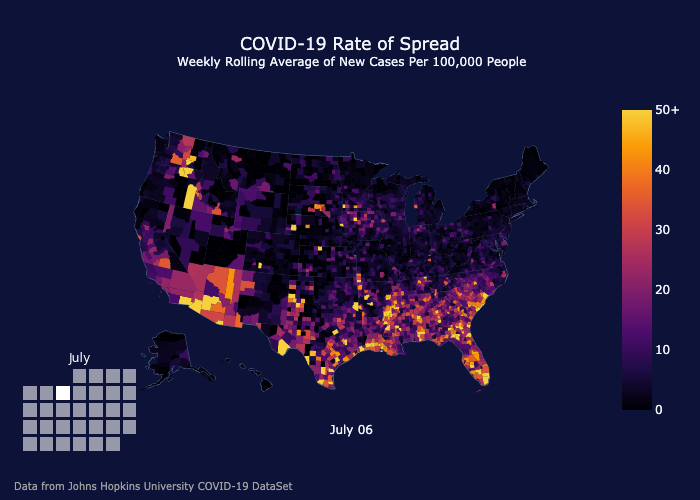

In [675]:
calendar = get_calendar(2020, 7,7)
background = PILImage.open('gitignore-county-spread-images/2020-07-06-00-00.png')
background.paste(calendar, (20,350), calendar)
display(background)

In [671]:
(5,5,5)

(5, 5, 5)

In [566]:
h = bgcolor.lstrip('#')
start_color = [tuple(int(h[i:i+2], 16) for i in (0, 2, 4))]
end_color = (255, 255, 255)
spectrum = [a[0] for a in np.linspace(start_color, end_color, 8)]

[array([13., 18., 56.]),
 array([47.57142857, 51.85714286, 84.42857143]),
 array([ 82.14285714,  85.71428571, 112.85714286]),
 array([116.71428571, 119.57142857, 141.28571429]),
 array([151.28571429, 153.42857143, 169.71428571]),
 array([185.85714286, 187.28571429, 198.14285714]),
 array([220.42857143, 221.14285714, 226.57142857]),
 array([255., 255., 255.])]

In [676]:
originalData = get_county_percentages().T.clip(0, 50)

In [ ]:
display(draw_single_choropleth(2020, 7,6))

2020-07-06 00:00:00
